## Librerias

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
!nvidia-smi

Sun Oct 23 20:21:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## CNN

In [3]:
class CustomCNN(tf.Module):
    def __init__(self,name=None):
        super().__init__(name=name)
        self.inicial = tf.initializers.lecun_uniform(seed=1)
        #64x64
        self.Layer_1_Weights_Filter = tf.Variable(self.inicial((3,3,3,32)))
        self.Layer_1_Bias= tf.Variable(self.inicial((32,)))
        #32*32
        self.Layer_2_Weights_Filter = tf.Variable(self.inicial((3,3,32,32)))
        self.Layer_2_Bias= tf.Variable(self.inicial((32,)))
        #16x16
        self.Layer_3_Weights_Filter = tf.Variable(self.inicial((3,3,32,64)))
        self.Layer_3_Bias= tf.Variable(self.inicial((64,)))
        #8x8
        self.Layer_4_Weights_Filter = tf.Variable(self.inicial((3,3,64,64)))
        self.Layer_4_Bias= tf.Variable(self.inicial((64,)))
        #4x4
        self.Layer_1_Weights_Dense=tf.Variable(self.inicial((4*4*64,64)))  
        self.Layer_1_Bias_Dense=tf.Variable(self.inicial((64,)))

        self.Output_Layer=tf.Variable(self.inicial((64, 10)))
        self.Output_Bias=tf.Variable(self.inicial((10,)))   

    def Conv2D(self,x,W,b,strides=1):
        x=tf.nn.conv2d(x,W,strides=[1,strides,strides,1],padding='SAME')
        x=tf.nn.bias_add(x,b)
        x=tf.nn.relu(x)
        return x

    def MaxPool(self,x,k=2):
        return tf.nn.max_pool(x,ksize=[1,k,k,1],
                                strides=[1,k,k,1],
                                padding='SAME')
    def __call__(self,x):

        img=tf.cast(x,tf.float32)
        #64x64
        L1=self.Conv2D(img,self.Layer_1_Weights_Filter,self.Layer_1_Bias)
        L1=self.MaxPool(L1)

        #32x32
        L2=self.Conv2D(L1,self.Layer_2_Weights_Filter,self.Layer_2_Bias)
        L2=self.MaxPool(L2)

        #16x16
        L3=self.Conv2D(L2,self.Layer_3_Weights_Filter,self.Layer_3_Bias)
        L3=self.MaxPool(L3)

        #8x8
        L3=self.Conv2D(L3,self.Layer_4_Weights_Filter,self.Layer_4_Bias)
        L3=self.MaxPool(L3)

        #4x4
        L4=tf.reshape(L3,shape=[-1,4*4*64])
        L4=tf.matmul(L4,self.Layer_1_Weights_Dense)
        L4=tf.add(L4,self.Layer_1_Bias_Dense)
        L4=tf.nn.relu(L4)

        L5=tf.matmul(L4,self.Output_Layer)
        OutPut=tf.add(L5,self.Output_Bias)

        return OutPut

    def predict(self,x):

        img=tf.cast(x,tf.float32)
        #64x64
        L1=self.Conv2D(img,self.Layer_1_Weights_Filter,self.Layer_1_Bias)
        L1=self.MaxPool(L1)

        #32x32
        L2=self.Conv2D(L1,self.Layer_2_Weights_Filter,self.Layer_2_Bias)
        L2=self.MaxPool(L2)

        #16x16
        L3=self.Conv2D(L2,self.Layer_3_Weights_Filter,self.Layer_3_Bias)
        L3=self.MaxPool(L3)

        #8x8
        L3=self.Conv2D(L3,self.Layer_4_Weights_Filter,self.Layer_4_Bias)
        L3=self.MaxPool(L3)

        #4x4
        L4=tf.reshape(L3,shape=[-1,4*4*64])
        L4=tf.matmul(L4,self.Layer_1_Weights_Dense)
        L4=tf.add(L4,self.Layer_1_Bias_Dense)
        L4=tf.nn.relu(L4)

        L5=tf.matmul(L4,self.Output_Layer)
        OutPut=tf.add(L5,self.Output_Bias)

        OutPut=tf.nn.softmax(OutPut)

        OutPut=np.argmax(OutPut,axis=1)

        return OutPut

## Metricas

In [4]:
optimizador = tf.compat.v1.train.AdamOptimizer()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
#Para validation
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [5]:
@tf.function
def train_step(model,tdata, labels):
  with tf.GradientTape() as tape:
    predictions = model(tdata)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))
  gradients = tape.gradient(loss, model.trainable_variables)
  capped_grads_and_vars = [(grad,model.trainable_variables[index]) for index, grad in enumerate(gradients)]
  optimizador.apply_gradients(capped_grads_and_vars)
  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(model,tdata, labels):
  predictions = model(tdata)
  t_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))
  test_loss(t_loss)
  test_accuracy(labels, predictions)

## Lectura de TFRecords

In [6]:
feature_map = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([1], tf.int64),
    'label_cat': tf.io.FixedLenFeature([10], tf.int64),
}
def read_tf_record(example):
    example = tf.io.parse_single_example(example, feature_map)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    label = example['label']
    cat_label=example['label_cat']
    return image, label,cat_label


def get_dataset(filename):
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(read_tf_record)
    return dataset

60 60 [0 0 0 0 0 0 1 0 0 0]
1


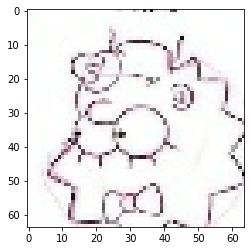

In [7]:
path_val='validation/'
path_train='train/'
batches_val=glob.glob(path_val+'*.tfrec')
batches_train=glob.glob(path_train+'*.tfrec')

batch=get_dataset(batches_train[0])
minibatches=list(batch.batch(60).as_numpy_iterator())
i=0
for minibatch in minibatches[0:1]:
    batch_x = minibatch[0]
    batch_y = minibatch[2]
    plt.imshow(batch_x[2])
    print(len(batch_x),len(batch_y),batch_y[0])
    i+=1
print(i)

## Función de entrenamiento

In [8]:
def fitting(model,EPOCHS=13,batch_size=40):
  path_train='train/'
  path_val='validation/'

  batches_train=glob.glob(path_train+'*.tfrec')
  batches_val=glob.glob(path_val+'*.tfrec')
  
  Train_L = []
  Test_L = []
  Train_A = []
  Test_A = []

  for epoch in range(EPOCHS):
    for ind,batch_element in enumerate(batches_train):
      batch=get_dataset(batch_element)
      minibatches=list(batch.batch(batch_size).as_numpy_iterator())

      batch_val=get_dataset(batches_val[ind])
      minibatches_val=list(batch_val.batch(10).as_numpy_iterator())

      for ind,minibatch in enumerate(minibatches):
        batch_x = minibatch[0]
        batch_y = minibatch[2]
        train_step(model,batch_x/255.0,batch_y)
        test_step(model,minibatches_val[ind][0]/255.0,minibatches_val[ind][2])

    template = 'Epoch {}, Perdida: {}, Exactitud: {}, Perdida de prueba: {}, Exactitud de prueba: {}'
    if epoch%2==0:
        print(template.format(epoch+1,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100))
    
    Train_L.append(train_loss.result())
    Train_A.append(train_accuracy.result())
    Test_L.append(test_loss.result())
    Test_A.append(test_accuracy.result())
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

  return (Train_A, Test_A), (Train_L, Test_L)

In [9]:
model=CustomCNN()
(Train_A, Test_A), (Train_L, Test_L) = fitting(model)

Epoch 1, Perdida: 1.626283049583435, Exactitud: 45.28888702392578, Perdida de prueba: 1.5902866125106812, Exactitud de prueba: 45.986392974853516
Epoch 3, Perdida: 0.6249366402626038, Exactitud: 80.68888854980469, Perdida de prueba: 0.7373147010803223, Exactitud de prueba: 77.59637451171875
Epoch 5, Perdida: 0.3570942282676697, Exactitud: 89.17777252197266, Perdida de prueba: 0.5553287267684937, Exactitud de prueba: 83.99092864990234
Epoch 7, Perdida: 0.2317998707294464, Exactitud: 92.56666564941406, Perdida de prueba: 0.5196818709373474, Exactitud de prueba: 86.03174591064453
Epoch 9, Perdida: 0.15233899652957916, Exactitud: 95.24444580078125, Perdida de prueba: 0.5147614479064941, Exactitud de prueba: 86.03174591064453
Epoch 11, Perdida: 0.08824048191308975, Exactitud: 97.28888702392578, Perdida de prueba: 0.5311417579650879, Exactitud de prueba: 87.5283432006836
Epoch 13, Perdida: 0.06590425968170166, Exactitud: 97.74444580078125, Perdida de prueba: 0.5902257561683655, Exactitud de 

## Curvas de aprendizaje

### Accuracy

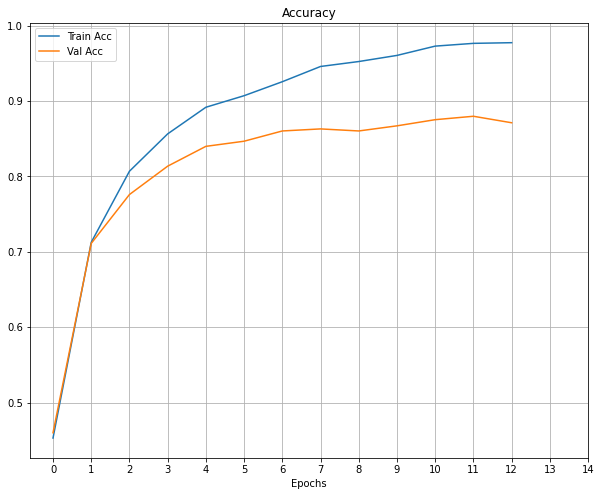

In [10]:
plt.figure(figsize=(10,8))
plt.plot(Train_A)
plt.plot(Test_A)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train Acc", "Val Acc"])
#plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(np.arange(0,15))
plt.grid()
plt.savefig("Accuracy_Plot.png",dpi=300,bbox_inches='tight')
plt.show()

### Loss

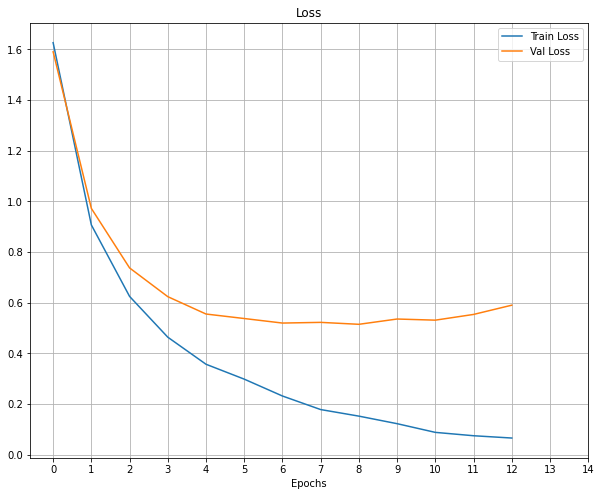

In [11]:
plt.figure(figsize=(10,8))
plt.plot(Train_L)
plt.plot(Test_L)
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend(["Train Loss", "Val Loss"])

plt.xticks(np.arange(0,15))
plt.grid()
plt.savefig("Loss_Plot.png",dpi=300,bbox_inches='tight')
plt.show()

## Test

In [16]:
path_test='test/'
batches_test=glob.glob(path_test+'*.tfrec')


batch=get_dataset(batches_test[1])
all_imgs=[]
all_labels=[]
all_labels_cat=[]
for i in batches_test:
    batch=get_dataset(i)
    for image,label,label_cat in batch:
        all_imgs.append(image.numpy()/255)
        all_labels.append(label[0])
        all_labels_cat.append(label_cat)

y_predict=model.predict(all_imgs)

In [19]:
from sklearn.metrics import accuracy_score

score=accuracy_score(all_labels,y_predict)

print("Precision de:{}".format(score))

Precision de:0.87


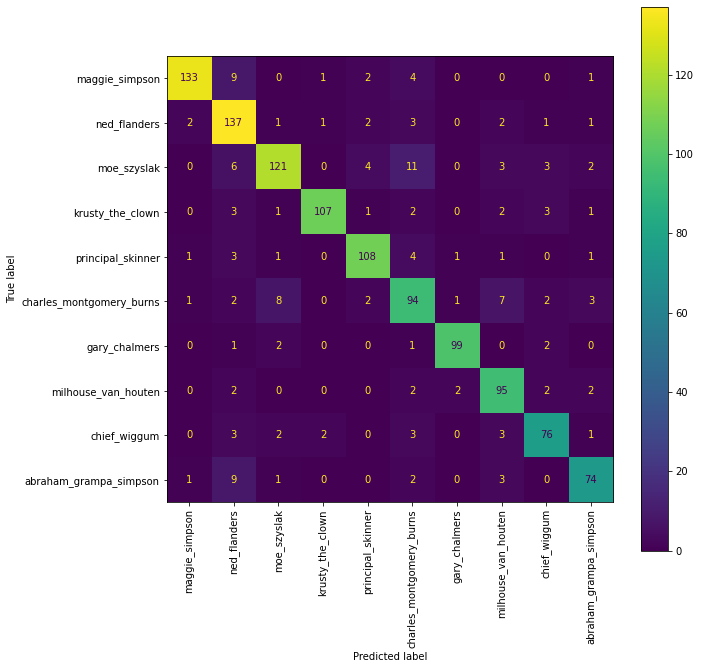

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

targets = ["maggie_simpson",
           "ned_flanders",
           "moe_szyslak",
           "krusty_the_clown",
           "principal_skinner",
           "charles_montgomery_burns",
           "gary_chalmers",
           "milhouse_van_houten",
           "chief_wiggum",
           "abraham_grampa_simpson"]

figure,ax=plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(all_labels, 
                                        y_predict,
                                        display_labels=targets,
                                        xticks_rotation='vertical',
                                        ax=ax)
plt.savefig("CFMatrix_Plot.png",dpi=300,bbox_inches='tight')
plt.show()

In [20]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, y_predict, target_names=targets))

                          precision    recall  f1-score   support

          maggie_simpson       0.96      0.89      0.92       150
            ned_flanders       0.78      0.91      0.84       150
             moe_szyslak       0.88      0.81      0.84       150
        krusty_the_clown       0.96      0.89      0.93       120
       principal_skinner       0.91      0.90      0.90       120
charles_montgomery_burns       0.75      0.78      0.76       120
           gary_chalmers       0.96      0.94      0.95       105
     milhouse_van_houten       0.82      0.90      0.86       105
            chief_wiggum       0.85      0.84      0.85        90
  abraham_grampa_simpson       0.86      0.82      0.84        90

                accuracy                           0.87      1200
               macro avg       0.87      0.87      0.87      1200
            weighted avg       0.87      0.87      0.87      1200



In [21]:
with open('classification_report.txt', 'w') as f:
    f.write(classification_report(all_labels, y_predict, target_names=targets))